### Source of Saliency Map Info
https://usmanr149.github.io/urmlblog/cnn/2020/05/01/Salincy-Maps.html

For this, I utilized Paul's "cnn-1-simple-fast.py"

In [6]:
# FIRST CNN attempt
# reaches 1.0 accuracy, but only about a max of 6.5% validation accuracy

import os

from keras.preprocessing.image import load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

In [8]:

# Read in csv files.
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')
sample_submission = pd.read_csv('../sample_submission.csv')

turtle_ids = sorted(np.unique(train.turtle_id)) + ['new_turtle']
turtle_num_lookup = dict(zip(turtle_ids, np.arange(len(turtle_ids))))
turtle_id_lookup = {v: k for k, v in turtle_num_lookup.items()}
train["turtle_num"] = train["turtle_id"].map(turtle_num_lookup)


# Convert image_location strings to lowercase and ensure only allowed strings are present
# for df in [train, test]:
#   df.image_location = df.image_location.apply(lambda x: x.lower())
#   assert set(df.image_location.unique()) == set(['left', 'right', 'top'])


turtle_imgs_dir = "..\\image_datasets\\turtle_edge"
train_image_paths = [os.path.join(turtle_imgs_dir, "%s.JPG" % f) for f in train.image_id]
train_images = np.array([img_to_array(load_img(f, grayscale=True)) for f in train_image_paths]) / 255


In [34]:
tf.keras.backend.clear_session()

filtersize = (3,3)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, filtersize, activation='relu', input_shape=(224,224,1)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, filtersize, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, filtersize, activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, filtersize, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(train.turtle_id.nunique() + 1)
])



In [35]:
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

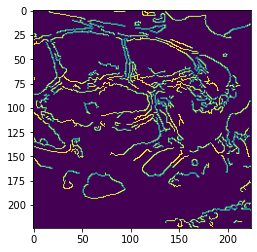

In [45]:
#Saliency Map Component
import tensorflow.keras as keras

#Load image to run model on
_img = keras.preprocessing.image.load_img('../image_datasets/turtle_edge/ID_0B15SK84.JPG',target_size=(224,224, 1))
_img = tf.image.rgb_to_grayscale(_img)
plt.imshow(_img)
plt.show()

In [47]:
#preprocess image to get it into the right format for the model
img = keras.preprocessing.image.img_to_array(_img)
# img = tf.image.rgb_to_grayscale(img)
img = img.reshape((1, *img.shape))
y_pred = model.predict(img)

In [48]:
#calculate the gradient with respect to the top class score to see which pixels in the image contribute the most:
images = tf.Variable(img, dtype=float)

with tf.GradientTape() as tape:
    pred = model(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
    loss = pred[0][class_idxs_sorted[0]]
    
grads = tape.gradient(loss, images)

dgrad_abs = tf.math.abs(grads)


#find the max of the absolute values of the gradient along each RGB channel
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)


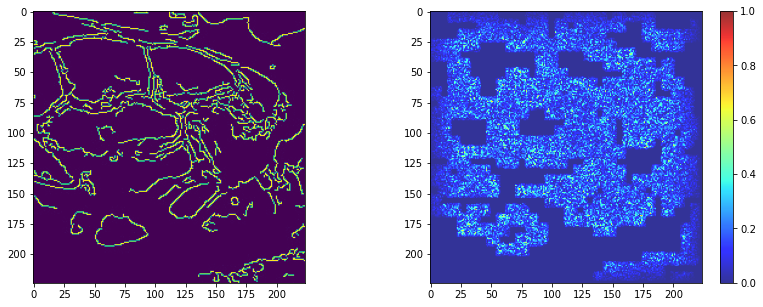

In [49]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(_img)
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)